### High-resolution Interpolation

In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
import scipy
from mpmath import *

mp.dps = 512
eps = 1e-64

In [331]:
mp.matrix(4).rows

4

In [11]:
mp.pretty = True

class IPRInterpolation:
    def __init__(self, N, lam, load_from_disk = False):
        self.N   = N 
        self.lam = lam 
        self.x   = mp.linspace(-1, 1, N+1)[:-1]

        self.Winv = self.computeWInv(self.x, N)
        self.P    = self.computeInterpolationMatrix(N) 

        #for i in range(self.Winv.rows):
        #    for j in range(self.Winv.cols):
        #        self.Winv[i, j] = chop(self.Winv[i, j], 1e-16)
                
        #print(self.Winv)

        self.int  = self.P * self.Winv * self.dft 
        #for i in range(self.int.rows):
        #    for j in range(self.int.cols):
        #        self.int[i, j] = chop(self.int[i, j], 1e-16)

        directory = "interpolation/"
        self.np_Winv = np.array(self.Winv.tolist(), dtype=complex)
        self.np_Winv.tofile(directory + f"WInv_N={N}_lambda={lam}.bin")

        self.np_P    = np.array(self.P.tolist(), dtype=float)
        self.np_P.tofile(directory + f"Polynomial_N={N}_lambda={lam}.bin")

        self.np_int  = np.array(self.int.tolist(), dtype=complex)
        self.np_int.tofile(directory + f"Interpolant_N={N}_lambda={lam}.bin")

    def polynomial(self, l, lam, x): 
        return mp.gegenbauer(l, lam, x, zeroprec=1000)

    #Construct matrices T and V recursively for arbitrary lambda
    def computeWInv(self, x, N): 
        # Even 
        W        = mp.matrix(N, N)
        pol      = mp.matrix(N) 
        self.dft = self.dftmat(N) 
        
        for l in range(N):
            # evaluate Gegenbauer polynomials
            for j in range(N): 
                pol[j, 1] = self.polynomial(l, self.lam, x[j])

            #compute DFT 
            pol = self.dft * pol

            #write to W 
            for j in range(N): 
                W[j, l] = pol[j, 1]

        #return self.invertMatrix(W, 1e-8)
        return mp.inverse(W) 
    
    def dftmat(self, N):
        
        M = mp.matrix(N, N)
        for i in range(N):
            for j in range(N): 
                M[i, j] = mp.exp(-2j * mp.pi * i * j / N)
        
        return M
    
    def invertMatrix(self, M, cutoff):
        U, s, Vh = mp.svd(M)
        sinv = mp.diag(s) 

        plt.title("Singular values of W")
        plt.yscale("log")
        plt.plot(np.abs(s))
        plt.show() 

        print(np.abs(s))

        r = M.cols
        if M.rows < M.cols:
            r = M.rows
        for i in range(r):
            if s[i] < cutoff:
                sinv[i, i] = 0
            else:
                sinv[i, i] = 1/s[i]

        Vht = Vh.transpose_conj()
        Ut  = U.transpose_conj()
        f1  = sinv * Ut
        f2  = Vht * f1 
        return  f2
    
    def computeInterpolationMatrix(self, N):
        x = self.getInterpolationGrid(N) 
        P = mp.matrix(2* (N-2), N) 
        for i in range(2* (N-2)):
            for j in range(N): 
                P[i, j] = self.polynomial(j, self.lam, x[i])
        return P
    
    def getGrid(self, N):
        return mp.matrix(mp.linspace(-1, 1,   N+1)[:-1])
    
    def getInterpolationGrid(self, N):
        dx = mp.mpf(2) / mp.mpf(N)
        return mp.matrix(mp.linspace(-1 + dx * 0.75, 1 - dx * 0.75, 2* (N - 2)))
    
    def interpolate(self, fhat):
        frec   = np.matrix(self.int.tolist(), dtype=complex) @ fhat 
        return np.squeeze(np.asarray(frec.flatten()))
    

In [61]:
N = 10 
x   = np.linspace(-1, 1,   N + 1)[:-1]
xhr = np.linspace(-1, 1, 2*N+ 1)[:-1] + 1 / (2*N)
x, xhr

(array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
 array([-0.95, -0.85, -0.75, -0.65, -0.55, -0.45, -0.35, -0.25, -0.15,
        -0.05,  0.05,  0.15,  0.25,  0.35,  0.45,  0.55,  0.65,  0.75,
         0.85,  0.95]))

In [12]:

inter = IPRInterpolation(32, 0.5)

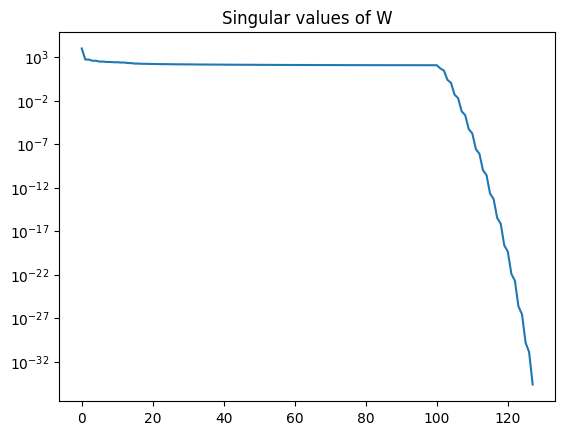

[9514.835219111227709820863746334722617845741436179470008935036293583235876482544175545317151272798035751528010082826046517428920990239266001130431154291952248142426343779178658263539818695190211331438050599142945193307862411788339855074805568265838937776669
 510.488771595835310591680069903770854521940657159071211658111359188836872256704632145569615424759142000373910003285385175382304157218741492639633587711000190516030643510291375593168212586432139473076133402567285798554250316746560477737858498781035233125018
 507.7881095826039895303972086028035764536590106790346117702888158023274581989121383639944787184061122453266950624473082172350111123802396138258796594028823918386211513564649180589164174729559142526435866151662032615400985898079207159359340136175261276241792
 369.470815097313021646290887405755867242659279411687665896043492130439614287003716300351158565706572824692011878301225677147937988927114383976799288897248095305725211678948071473328037683730961582253913657591800097014913666

In [325]:

inter = IPRInterpolation(128, 1)

In [318]:
for lam in [mp.mpf(0.5)]: 
    for N in range(32, 33): 
        print("Lambda = ", lam, " N = ", N)
        inter = IPRInterpolation(N, lam)
        #x     = np.array(inter.getGrid(N).tolist(), dtype=float)
        #xhr   = np.array(inter.getInterpolationGrid(N).tolist(), dtype=float)
#
        x   = np.linspace(-1, 1,   N + 1)[:-1]
        xhr = np.linspace(-1, 1, 2*N+ 1)[:-1] + 1 / (2*N)
#
        def f(x):
            return np.sin(20*x)
        fhat = scipy.fft.fft((f(x)))
#
        frec  = inter.interpolate(fhat) 
#
        plt.title(f"New interpolation: {np.mean(np.abs(frec - np.real(f(xhr)))[1:-3]):5.5e}")
        plt.plot(x, f(x), label="f") 
        plt.plot(xhr[1:-3], frec[1:-3], label="frec")
        plt.legend()
        plt.show()

Lambda =  0.5  N =  32


KeyboardInterrupt: 

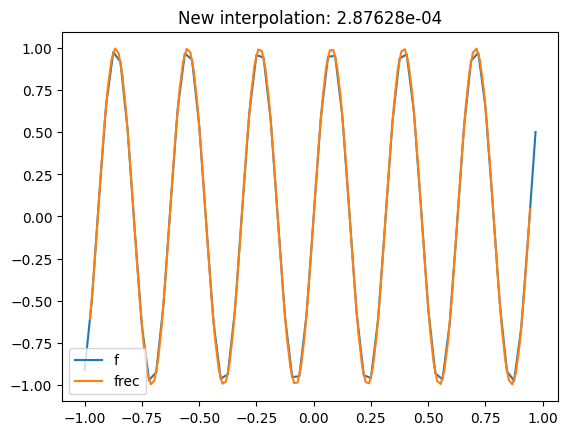

In [295]:

x   = np.linspace(-1, 1,   N + 1)[:-1]
xhr = np.linspace(-1, 1, 2*N+ 1)[:-1] + 1 / (2*N)
#
def f(x):
    return np.sin(20*x)
fhat = scipy.fft.fft((f(x)))
#
frec  = inter.interpolate(fhat) 
#
plt.title(f"New interpolation: {np.mean(np.abs(frec - np.real(f(xhr)))[1:-3]):5.5e}")
plt.plot(x, f(x), label="f") 
plt.plot(xhr[1:-3], frec[1:-3], label="frec")
plt.legend()
plt.show()

In [ ]:
for N in range(50, 128, 1): 
    inter = IPRInterpolation(N, mp.mpf(0.5))
    x     = np.array(inter.getGrid(N).tolist(), dtype=float)
    xhr   = np.array(inter.getInterpolationGrid(N).tolist(), dtype=float)

    x   = np.linspace(-1, 1,   N + 1)[:-1]
    xhr = np.linspace(-1, 1, 2*N+ 1)[:-1] + 1 / (2*N)

    def f(x):
        return x
    fhat = scipy.fft.fft((f(x)))

    print(fhat)
    frec  = inter.interpolate(fhat) 

    plt.title(f"New interpolation: {np.mean(np.abs(frec - np.real(f(xhr)))):5.5e}")
    plt.plot(x, f(x), label="f") 
    plt.plot(xhr, frec, label="frec")
    plt.legend()
    plt.show()

In [289]:
import matplotlib.pyplot as plt 
import numpy as np 
import scipy
import sys

orig_stdout = sys.stdout
f = open('IPRInterpolationTables.h', 'w')
sys.stdout = f



def printCMatrix(mat, name):
    n, m = mat.shape    

    print(f"const static gamer_float_complex  {name}[{n}][{m}] = ", end="")
    print("{")
    for i in range(n):
        print("{", end="")
        for j in range(m):
            print(f"{np.real(mat[i,j]):10.64f}, {np.imag(mat[i,j]):10.64f}", end="")
            if j != m - 1:
                print(", ", end="")
        

        print("}", end=",\n")  
    print("}", end=";\n")  

print(
r"""
# ifndef __IPR_INTERPOLATION_TABLES_H__
# define __IPR_INTERPOLATION_TABLES_H__

# include "CUFLU.h"
# include "Macro.h"


// **********************************************************************************************************
// ** Precomputed IPR (Inverse Polynomial Reconstruction) interpolation tables                             **
// ** N             = 2-60                                                                                 **
// ** LAMBDA        = 0.5                                                                                  **
// **********************************************************************************************************""")

print("")

lam = 0.5

first = 1

Ns     = np.arange(2, 10)
totalN = len(Ns)
for N in range(2, 10):


    table = np.fromfile(f"interpolation/Interpolant_N={N}_lambda={lam}.bin", dtype=complex).reshape(2 * N, N) 


    printCMatrix(table, f"IPR_N{N}")
    print("")


print(
r"""
static const ipr_float* IPR_Tables[""", end="")
print(totalN, end="")
print(
r"""] = {""")

for N in range(2, 10):

    print(f"&IPR_N{N}[0][0], ", end="")
    
print(
r"""
};

# endif // # ifndef __IPR_INTERPOLATION_TABLES_H__""")


sys.stdout = orig_stdout
f.close()

# Test decay of g with inverted W

In [94]:

from scipy.linalg import lu, inv


class IPRInterpolation:
    def __init__(self, N, lam):
        self.lam  = lam 
        self.grid = np.linspace(0, 1, N) 
        print(self.shiftx(self.grid))
        self.W   = self.directW(self.shiftx(self.grid), int(len(self.grid)/2), self.lam)
    
    def interpolate(self, input): 
        #Aliases
        N           = len(input)
        x           = np.linspace(0, 1, 2 * N)
        psi         = input.astype(np.csingle).astype(np.cdouble)
        
        fhat        = scipy.fft.fft(psi)
        g, h        = self.gaussWithTruncation(self.W, fhat)
        yint        = self.reconstruct(g, self.lam, self.shiftx(x))
        return g, h, yint  

    def C(self, x, lam, N): 
        return scipy.special.eval_gegenbauer(N,lam, x)

    #Construct matrices T and V recursively for arbitrary lambda
    def directW(self, x, N, lam): 
        # Even 
        W = np.zeros((2*N, 2*N), dtype=complex)
        
        for l in range(2*N):
            W[:, l] = scipy.fft.fft(self.C(x, lam, l))

        return W 

    def reconstruct(self, g, lam, x): 
        n = len(x)
        f = np.zeros(x.shape, dtype=complex)
        for l, coeff in enumerate(g):
            f += coeff * self.C(x, lam, l)

        return f

    def shiftx(self, x):
        dx = x[1] - x[0]
        a  = x[0]
        b  = x[-1] + dx
        return  (x - (a + b)/2)/ ((b - a)/2)
    
        

    def gaussWithTruncation(self, A,B):
        """
        Solve Ax = B using Gaussian elimination and LU decomposition with truncation for stability of IPR
        """
        # LU decomposition with pivot
        p, l, u = lu(A, permute_l=False)
        
        # forward substitution to solve for Ly = B
        y = np.zeros(B.size, dtype=np.csingle)
        for m, b in enumerate((p.T @ B).flatten()):
            y[m] = b
            # skip for loop if m == 0
            if m:
                for n in range(m):
                    y[m] -= y[n] * l[m,n]
            y[m] /= l[m, m]

        # truncation for IPR
        z = np.copy(y) 
        c = np.abs(y) < 10 * np.finfo(np.single).eps
        y[c] = 0

        # backward substitution to solve for y = Ux
        x = np.zeros(B.size, dtype=np.csingle)
        lastidx = B.size - 1  # last index
        for midx in range(B.size):
            m = B.size - 1 - midx  # backwards index
            x[m] = y[m]
            if midx:
                for nidx in range(midx):
                    n = B.size - 1  - nidx
                    x[m] -= x[n] * u[m,n]
            x[m] /= u[m, m]
        return x, z


13772.593838009136

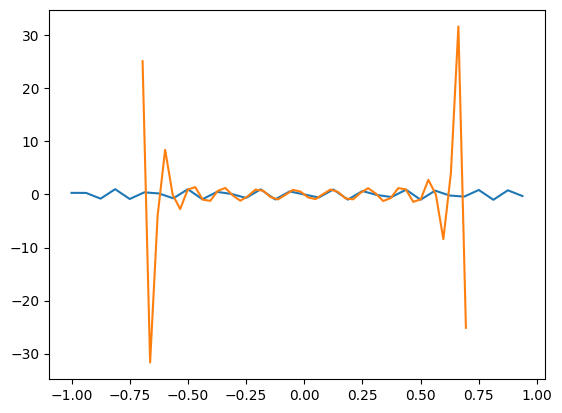

In [30]:

N = 32
lam = 0.5
directory = "interpolation/"
interplator = np.fromfile(directory + f"Interpolant_N={N}_lambda={lam}.bin", dtype=complex).reshape(2 * (N - 2), N)

def func(x): 
    return np.sin(60 * x)

x  = np.linspace(-1, 1, N+1)[:-1]
dx = x[1] - x[0]
xh = np.linspace(-1 + 0.75 * dx, 1 - 0.75*dx, 2 * (N-2))
f = func(x) 
fr = interplator @ f
plt.plot(x, f)
plt.plot(xh[8:-8], fr[8:-8])
np.mean(np.abs(fr - func(xh)))

[-1.      -0.96875 -0.9375  -0.90625 -0.875   -0.84375 -0.8125  -0.78125
 -0.75    -0.71875 -0.6875  -0.65625 -0.625   -0.59375 -0.5625  -0.53125
 -0.5     -0.46875 -0.4375  -0.40625 -0.375   -0.34375 -0.3125  -0.28125
 -0.25    -0.21875 -0.1875  -0.15625 -0.125   -0.09375 -0.0625  -0.03125
  0.       0.03125  0.0625   0.09375  0.125    0.15625  0.1875   0.21875
  0.25     0.28125  0.3125   0.34375  0.375    0.40625  0.4375   0.46875
  0.5      0.53125  0.5625   0.59375  0.625    0.65625  0.6875   0.71875
  0.75     0.78125  0.8125   0.84375  0.875    0.90625  0.9375   0.96875]
gdir:  [ 1.91505978e-11-6.01853108e-36j -2.41472153e-17+5.38089984e-19j
  9.10946145e-12+3.29138418e-37j -3.53255091e-17-3.97414725e-20j
  3.92273461e-12+7.34683969e-40j -4.33384407e-17+3.56037465e-21j
  1.52550791e-12+5.92877049e-39j -4.69324015e-17+7.31226955e-23j
  5.33927767e-13+6.77929840e-39j -4.56051009e-17-1.27382825e-23j
  1.67433796e-13+2.33726004e-39j -3.96945050e-17+9.97558590e-24j
  4.69772325e-14+7

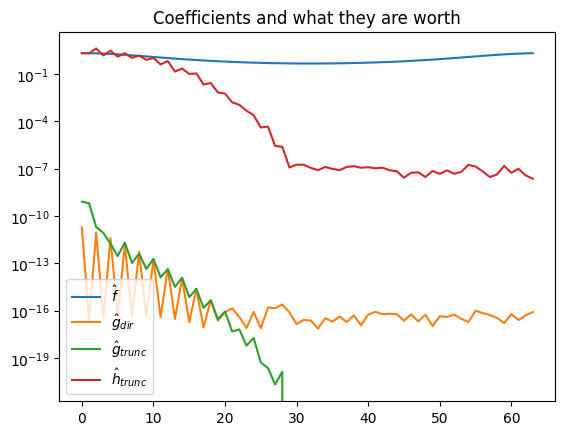

In [95]:
import numpy as np 
import scipy 
import matplotlib.pyplot as plt 

N = 64
lam = 20.0
directory = "interpolation/"
Winv = np.fromfile(directory + f"WInv_N={N}_lambda={lam}.bin", dtype=complex).reshape(N, N)
ipr = IPRInterpolation(N, lam) 

def func(x): 
    return x**32

x = np.linspace(-1, 1, N + 1)[:-1]
f = func(x) 

fhat = scipy.fft.fft(f)
gdir = Winv @ fhat 

g, h, _ = ipr.interpolate(f) 

print("gdir: ", gdir)
print("g: ", g)
plt.title("Coefficients and what they are worth") 
plt.yscale("log")
plt.plot(np.abs(fhat), label=r"$\hat{f}$")
plt.plot(np.abs(gdir), label=r"$\hat{g}_{dir}$")
plt.plot(np.abs(g),    label=r"$\hat{g}_{trunc}$")
plt.plot(np.abs(h),    label=r"$\hat{h}_{trunc}$")
plt.legend()
plt.show()